## Imports

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from resnet import ResNet
from training import run_epoch
import matplotlib.pyplot as plt
from data import RamanSpectraDataset  
import numpy as np
import optuna
from optuna.trial import Trial
from augment import AugmentedWrapper
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score

c:\Users\Irem\Documents\DI504\Project\Python\venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset

In [3]:
data_path = "Data/ALS baseline corrected normalized merged" # Change based on your dataset location

dataset = RamanSpectraDataset(
    data_path,
    augment=False,       
    offline_aug=False     
)
sample_x, _ = dataset[0]
input_dim = sample_x.shape[-1]

print(f"Raw dataset size (before split): {len(dataset)}")
print(f"Input dimension: {input_dim}")

Raw dataset size (before split): 4500
Input dimension: 2030


Split the dataset into three parts:
-	70% for training
-	15% for validation
-	15% for testing 

And do data augmentation to training data.

In [4]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

print(f"Training samples (only raw): {len(train_set)}")

train_set = AugmentedWrapper(train_set, num_aug=2)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

print(f"Training samples (with augentation added): {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")

Training samples (only raw): 3150
Training samples (with augentation added): 9450
Validation samples: 675
Test samples: 675


## Hyperparameter tuning with Optuna

This code uses Optuna to find the best model settings.

- It tests different values for layer sizes and learning rate
- A small model is trained for 5 epochs in each trial
- The goal is to find the setting that gives the lowest validation loss
- After 10 trials the best settings are printed

In [5]:
def objective(trial: Trial):
    hidden_sizes = [
        trial.suggest_categorical("hidden_1", [32, 64, 128]),
        trial.suggest_categorical("hidden_2", [64, 128, 256]),
        trial.suggest_categorical("hidden_3", [128, 256, 512])
    ]
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    model = ResNet(
        hidden_sizes=hidden_sizes,
        num_blocks=[2, 2, 2],
        input_dim=input_dim,
        n_classes=1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Short training for tuning
    for epoch in range(1, 6):
        train_loss, *_ = run_epoch(epoch, model, train_loader, cuda=torch.cuda.is_available(),
                                   training=True, optimizer=optimizer)
        val_loss, *_ = run_epoch(epoch, model, val_loader, cuda=torch.cuda.is_available(),
                                 training=False)

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best params:", study.best_params)

[I 2025-06-20 19:51:15,749] A new study created in memory with name: no-name-79d760b0-202c-4fd0-b037-7070b090b3ba
Epoch 5 Val: 100%|██████████| 22/22 [00:00<00:00, 23.71it/s]
[I 2025-06-20 19:53:07,292] Trial 0 finished with value: 0.05972660863978995 and parameters: {'hidden_1': 128, 'hidden_2': 128, 'hidden_3': 128, 'lr': 4.108830061086429e-05}. Best is trial 0 with value: 0.05972660863978995.
Epoch 5 Val: 100%|██████████| 22/22 [00:00<00:00, 24.18it/s]
[I 2025-06-20 19:54:44,648] Trial 1 finished with value: 1.8035394015135588 and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 256, 'lr': 0.0026767361262015317}. Best is trial 0 with value: 0.05972660863978995.
Epoch 5 Val: 100%|██████████| 22/22 [00:00<00:00, 23.54it/s]
[I 2025-06-20 19:56:36,992] Trial 2 finished with value: 0.21592055116538647 and parameters: {'hidden_1': 128, 'hidden_2': 128, 'hidden_3': 128, 'lr': 0.007296015663198434}. Best is trial 0 with value: 0.05972660863978995.
Epoch 5 Val: 100%|██████████| 22/22

Best params: {'hidden_1': 128, 'hidden_2': 256, 'hidden_3': 512, 'lr': 0.00010692720538811244}


## Define model

This part set up final model using the best parameters found by Optuna

- `best_hidden` stores the best layer sizes
- `best_lr` stores the best learning rate
- A new `ResNet` model is created with these settings
- The optimizer (Adam) is initialized with the best learning rate

In [6]:
best_hidden = [
    study.best_params["hidden_1"],
    study.best_params["hidden_2"],
    study.best_params["hidden_3"]
]
best_lr = study.best_params["lr"]

model = ResNet(
    hidden_sizes=best_hidden,
    num_blocks=[2, 2, 2],
    input_dim=input_dim,
    n_classes=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

## Define metrics

In [7]:
train_losses, val_losses = [], []
train_maes, val_maes = [], []
train_rmses, val_rmses = [], []
train_r2s, val_r2s = [], []
train_loss_iters, val_loss_iters = [], []

## Training

This loop trains the model for 20 epochs and tracks its performance.

- In each epoch model is trained ontraining set and evaluated on the validation set
- Performance metrics are collected: Loss, MAE (mean absolute error), RMSE (root mean squared error) R^2 score  and Kappa score
- Batch level losses are also stored to later plot smooth loss curves
- At the end of each epoch training and validation results are printed

In [8]:
for epoch in range(1, 21):
    train_loss, train_mae, train_rmse, train_r2, train_kappa, train_conf, train_batch_losses = run_epoch(
        epoch, model, train_loader, cuda=torch.cuda.is_available(), training=True, optimizer=optimizer
    )
    val_loss, val_mae, val_rmse, val_r2, val_kappa, val_conf, val_batch_losses = run_epoch(
        epoch, model, val_loader, cuda=torch.cuda.is_available(), training=False
    )

    train_loss_iters.extend(train_batch_losses)
    val_loss_iters.extend(val_batch_losses)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)

    print(f"Epoch {epoch}")
    print(f"  Train: Loss={train_loss:.4f}, MAE={train_mae:.4f}, RMSE={train_rmse:.4f}, R2={train_r2:.4f}, Kappa={train_kappa:.4f}")
    print(f"  Val  : Loss={val_loss:.4f}, MAE={val_mae:.4f}, RMSE={val_rmse:.4f}, R2={val_r2:.4f}, Kappa={val_kappa:.4f}")

Epoch 1 Val: 100%|██████████| 22/22 [00:01<00:00, 19.22it/s]


Epoch 1
  Train: Loss=2.3767, MAE=0.4023, RMSE=0.7741, R2=0.6989, Kappa=0.8495
  Val  : Loss=0.1931, MAE=0.2815, RMSE=0.5305, R2=0.8560, Kappa=0.9208


Epoch 2 Val: 100%|██████████| 22/22 [00:01<00:00, 19.44it/s]


Epoch 2
  Train: Loss=0.1055, MAE=0.0999, RMSE=0.3187, R2=0.9489, Kappa=0.9744
  Val  : Loss=0.0482, MAE=0.0415, RMSE=0.2037, R2=0.9788, Kappa=0.9895


Epoch 3 Val: 100%|██████████| 22/22 [00:01<00:00, 19.43it/s]


Epoch 3
  Train: Loss=0.0799, MAE=0.0608, RMSE=0.2497, R2=0.9687, Kappa=0.9843
  Val  : Loss=0.1444, MAE=0.1837, RMSE=0.4286, R2=0.9060, Kappa=0.9495


Epoch 4 Val: 100%|██████████| 22/22 [00:01<00:00, 19.52it/s]


Epoch 4
  Train: Loss=0.0615, MAE=0.0368, RMSE=0.1925, R2=0.9814, Kappa=0.9907
  Val  : Loss=0.0453, MAE=0.0311, RMSE=0.1764, R2=0.9841, Kappa=0.9920


Epoch 5 Val: 100%|██████████| 22/22 [00:01<00:00, 19.26it/s]


Epoch 5
  Train: Loss=0.0528, MAE=0.0280, RMSE=0.1675, R2=0.9859, Kappa=0.9930
  Val  : Loss=0.0575, MAE=0.0474, RMSE=0.2177, R2=0.9758, Kappa=0.9881


Epoch 6 Val: 100%|██████████| 22/22 [00:01<00:00, 19.23it/s]


Epoch 6
  Train: Loss=0.0344, MAE=0.0101, RMSE=0.1003, R2=0.9949, Kappa=0.9975
  Val  : Loss=0.0695, MAE=0.0430, RMSE=0.2073, R2=0.9780, Kappa=0.9892


Epoch 7 Val: 100%|██████████| 22/22 [00:01<00:00, 19.18it/s]


Epoch 7
  Train: Loss=0.0469, MAE=0.0193, RMSE=0.1403, R2=0.9901, Kappa=0.9951
  Val  : Loss=0.0938, MAE=0.0667, RMSE=0.2582, R2=0.9659, Kappa=0.9828


Epoch 8 Val: 100%|██████████| 22/22 [00:01<00:00, 19.46it/s]


Epoch 8
  Train: Loss=0.0752, MAE=0.0590, RMSE=0.2443, R2=0.9700, Kappa=0.9849
  Val  : Loss=0.0440, MAE=0.0252, RMSE=0.1587, R2=0.9871, Kappa=0.9936


Epoch 9 Val: 100%|██████████| 22/22 [00:01<00:00, 19.52it/s]


Epoch 9
  Train: Loss=0.0422, MAE=0.0179, RMSE=0.1345, R2=0.9909, Kappa=0.9955
  Val  : Loss=0.0836, MAE=0.0637, RMSE=0.2524, R2=0.9674, Kappa=0.9841


Epoch 10 Val: 100%|██████████| 22/22 [00:01<00:00, 19.26it/s]


Epoch 10
  Train: Loss=0.0468, MAE=0.0253, RMSE=0.1590, R2=0.9873, Kappa=0.9936
  Val  : Loss=0.4001, MAE=0.6237, RMSE=0.7916, R2=0.6795, Kappa=0.8411


Epoch 11 Val: 100%|██████████| 22/22 [00:01<00:00, 19.08it/s]


Epoch 11
  Train: Loss=0.0669, MAE=0.0561, RMSE=0.2368, R2=0.9718, Kappa=0.9859
  Val  : Loss=0.1359, MAE=0.1244, RMSE=0.3528, R2=0.9364, Kappa=0.9672


Epoch 12 Val: 100%|██████████| 22/22 [00:01<00:00, 19.40it/s]


Epoch 12
  Train: Loss=0.0464, MAE=0.0187, RMSE=0.1369, R2=0.9906, Kappa=0.9953
  Val  : Loss=0.0629, MAE=0.0430, RMSE=0.2073, R2=0.9780, Kappa=0.9892


Epoch 13 Val: 100%|██████████| 22/22 [00:01<00:00, 19.57it/s]


Epoch 13
  Train: Loss=0.0452, MAE=0.0232, RMSE=0.1522, R2=0.9884, Kappa=0.9942
  Val  : Loss=0.0438, MAE=0.0296, RMSE=0.1721, R2=0.9848, Kappa=0.9925


Epoch 14 Val: 100%|██████████| 22/22 [00:01<00:00, 19.30it/s]


Epoch 14
  Train: Loss=0.0440, MAE=0.0205, RMSE=0.1433, R2=0.9897, Kappa=0.9948
  Val  : Loss=0.3896, MAE=0.5348, RMSE=0.7313, R2=0.7265, Kappa=0.8769


Epoch 15 Val: 100%|██████████| 22/22 [00:01<00:00, 19.49it/s]


Epoch 15
  Train: Loss=0.0559, MAE=0.0345, RMSE=0.1857, R2=0.9827, Kappa=0.9913
  Val  : Loss=0.1237, MAE=0.0993, RMSE=0.3197, R2=0.9477, Kappa=0.9750


Epoch 16 Val: 100%|██████████| 22/22 [00:01<00:00, 19.65it/s]


Epoch 16
  Train: Loss=0.0589, MAE=0.0439, RMSE=0.2096, R2=0.9779, Kappa=0.9890
  Val  : Loss=0.0456, MAE=0.0326, RMSE=0.1886, R2=0.9818, Kappa=0.9910


Epoch 17 Val: 100%|██████████| 22/22 [00:01<00:00, 19.47it/s]


Epoch 17
  Train: Loss=0.0686, MAE=0.0565, RMSE=0.2382, R2=0.9715, Kappa=0.9857
  Val  : Loss=0.1620, MAE=0.1556, RMSE=0.3944, R2=0.9204, Kappa=0.9631


Epoch 18 Val: 100%|██████████| 22/22 [00:01<00:00, 19.77it/s]


Epoch 18
  Train: Loss=0.0337, MAE=0.0128, RMSE=0.1132, R2=0.9936, Kappa=0.9968
  Val  : Loss=0.0340, MAE=0.0207, RMSE=0.1440, R2=0.9894, Kappa=0.9947


Epoch 19 Val: 100%|██████████| 22/22 [00:01<00:00, 19.36it/s]


Epoch 19
  Train: Loss=0.0345, MAE=0.0131, RMSE=0.1145, R2=0.9934, Kappa=0.9967
  Val  : Loss=0.1281, MAE=0.1733, RMSE=0.4199, R2=0.9098, Kappa=0.9526


Epoch 20 Val: 100%|██████████| 22/22 [00:01<00:00, 19.69it/s]

Epoch 20
  Train: Loss=0.0248, MAE=0.0024, RMSE=0.0493, R2=0.9988, Kappa=0.9994
  Val  : Loss=0.0893, MAE=0.0785, RMSE=0.2802, R2=0.9598, Kappa=0.9793


In [9]:
torch.save(model.state_dict(), "cv_model.ckpt")
print("Model saved as cv_model.ckpt")

Model saved as cv_model.ckpt


## Performance evaluations

It plots to visualize training performance

- `plot_loss_graph`:
  - Draws smoothed loss curves (using moving average) for both training and validation and interpolates validation loss to match training iterations if needed.

- `plot_metric`:
  - Plots each metric (Loss, MAE, RMSE, R²) over 20 epochs
  - Saves each plot to a separate file

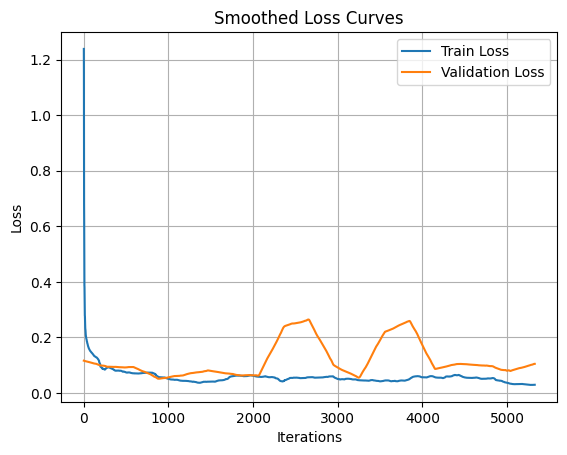

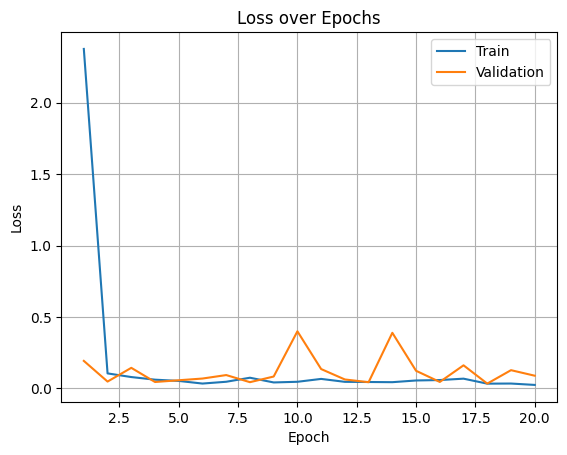

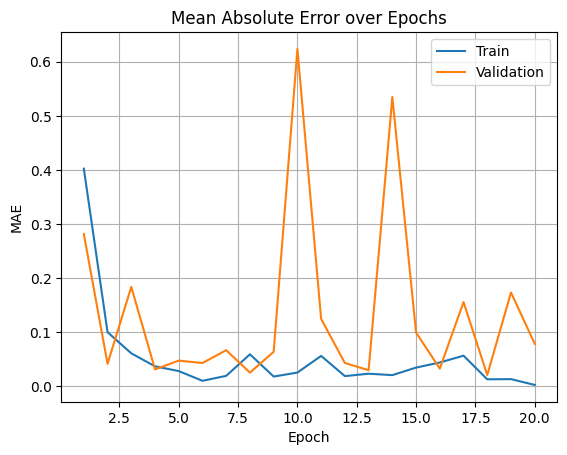

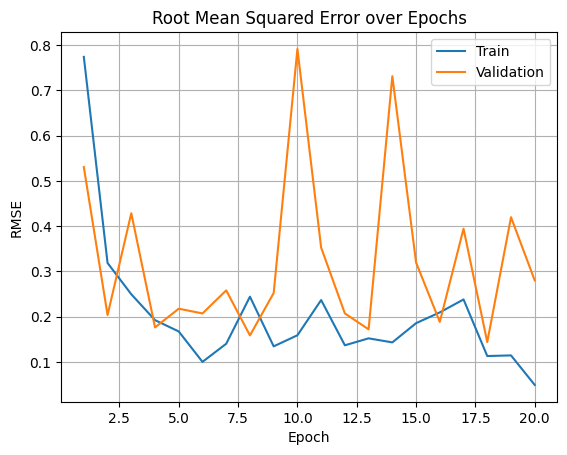

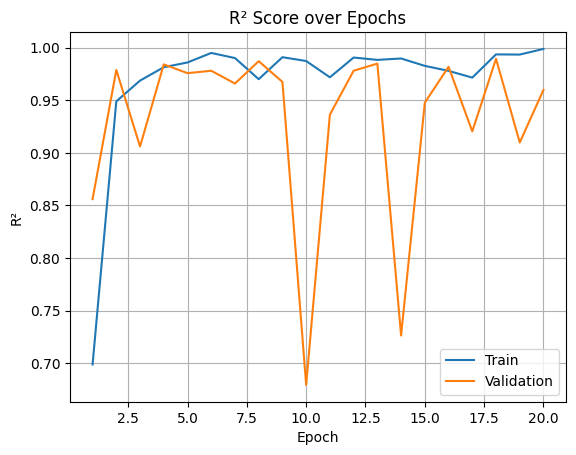

In [10]:
epochs = range(1, 21)

def plot_loss_graph(loss_list):
    """Plot smoothed training and validation loss curves using moving average.
    Validation loss is interpolated to match the number of training iterations.
    """
    plt.figure()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    train_loss = loss_list[0]
    val_loss = loss_list[1]

    if len(train_loss) > len(val_loss):
        val_loss_interp = np.interp(
            np.linspace(0, len(val_loss) - 1, len(train_loss)),
            np.arange(len(val_loss)),
            val_loss
        )
    else:
        val_loss_interp = val_loss

    filter_size = max(1, len(train_loss) // 10)
    kernel = np.ones(filter_size) / filter_size
    train_smoothed = np.convolve(train_loss, kernel, mode='valid')
    val_smoothed = np.convolve(val_loss_interp, kernel, mode='valid')

    plt.plot(train_smoothed, label='Train Loss')
    plt.plot(val_smoothed, label='Validation Loss')
    plt.legend()
    plt.title("Smoothed Loss Curves")
    plt.grid(True)
    plt.savefig("loss.png")

plot_loss_graph([train_loss_iters, val_loss_iters])
plt.savefig("loss_plot_smoothed.png")

def plot_metric(train_vals, val_vals, ylabel, title, filename):
    plt.figure()
    plt.plot(epochs, train_vals, label='Train')
    plt.plot(epochs, val_vals, label='Validation')
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)

plot_metric(train_losses, val_losses, "Loss", "Loss over Epochs", "loss_plot.png")
plot_metric(train_maes, val_maes, "MAE", "Mean Absolute Error over Epochs", "mae_plot.png")
plot_metric(train_rmses, val_rmses, "RMSE", "Root Mean Squared Error over Epochs", "rmse_plot.png")
plot_metric(train_r2s, val_r2s, "R²", "R² Score over Epochs", "r2_plot.png")

It plots confusion matrix results for test set.

Epoch Test Val: 100%|██████████| 22/22 [00:01<00:00, 18.87it/s]


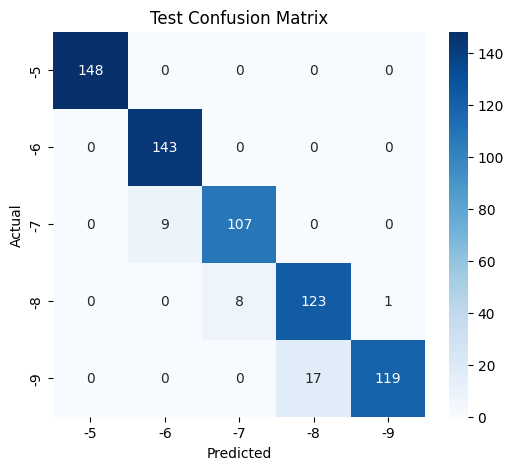

In [11]:
test_loss, test_mae, test_rmse, test_r2, test_kappa, test_conf, test_batch_losses = run_epoch(
    "Test", model, test_loader, cuda=torch.cuda.is_available(), training=False
)

test_confusion_df = pd.DataFrame(test_conf, index=[-5, -6, -7, -8, -9], columns=[-5, -6, -7, -8, -9])
plt.figure(figsize=(6,5))
sns.heatmap(test_confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.savefig("confusion_matrix_test.png")

Evaluates model on test set again

- Predictions are rounded to the nearest valid class label (between -9 and -5)

- `classification_report` prints precision, recall, and F1-score for each class
- `accuracy_score` computes the overall test accuracy

In [12]:
test_preds = []
test_actuals = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x).squeeze()
        preds = [min(-5, max(-9, int(round(p.item())))) for p in outputs]
        labels = [int(round(t.item())) for t in y]

        test_preds.extend(preds)
        test_actuals.extend(labels)

print("\nClassification Report:")
target_names = ['1e-5', '1e-6', '1e-7', '1e-8', '1e-9']
print(classification_report(test_actuals, test_preds, labels=[-5, -6, -7, -8, -9], target_names=target_names))

test_acc = accuracy_score(test_actuals, test_preds)
print(f"Test Accuracy: {test_acc:.3f}")


Classification Report:
              precision    recall  f1-score   support

        1e-5       1.00      1.00      1.00       148
        1e-6       0.94      1.00      0.97       143
        1e-7       0.93      0.92      0.93       116
        1e-8       0.88      0.93      0.90       132
        1e-9       0.99      0.88      0.93       136

    accuracy                           0.95       675
   macro avg       0.95      0.95      0.95       675
weighted avg       0.95      0.95      0.95       675

Test Accuracy: 0.948


Prints number of total parameter used in model

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model):,}")

Total trainable parameters: 6,462,657


## Baseline Comparison: Linear regression

A basic linear regression model is defined and trained as a baseline. Same evaluation plots are drawn for this one too.

Epoch Test-Baseline Val: 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]



Baseline Linear Regression Test Results:
  Loss=0.1207, MAE=0.0963, RMSE=0.3103, R2=0.9539, Kappa=0.9776

Baseline Linear Regression Classification Report:
              precision    recall  f1-score   support

        1e-5       0.85      1.00      0.92       148
        1e-6       0.96      0.81      0.88       143
        1e-7       0.92      0.84      0.88       116
        1e-8       0.86      0.90      0.88       132
        1e-9       0.96      0.95      0.96       136

    accuracy                           0.90       675
   macro avg       0.91      0.90      0.90       675
weighted avg       0.91      0.90      0.90       675

Baseline Linear Regression Test Accuracy: 0.904


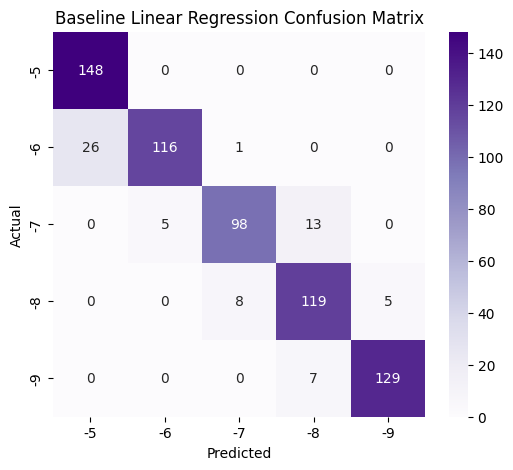

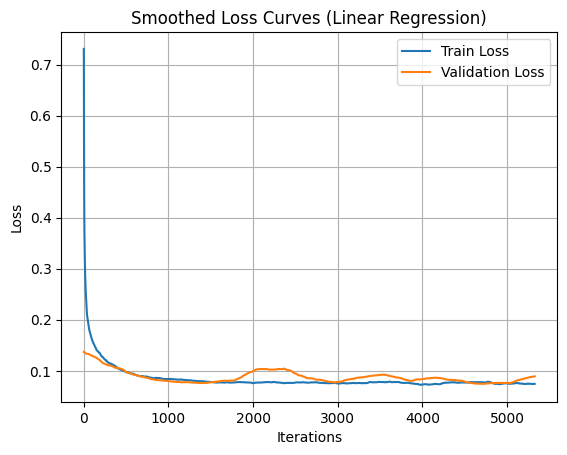

In [14]:
class SimpleLinearRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleLinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)

baseline_model = SimpleLinearRegression(input_dim).to(device)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)

baseline_train_losses, baseline_val_losses = [], []
baseline_train_batch_losses = []
baseline_val_batch_losses = []

for epoch in range(1, 21):
    train_loss, _, _, _, _, _, train_batches = run_epoch(
        epoch, baseline_model, train_loader, cuda=torch.cuda.is_available(),
        training=True, optimizer=baseline_optimizer
    )
    val_loss, _, _, _, _, _, val_batches = run_epoch(
        epoch, baseline_model, val_loader, cuda=torch.cuda.is_available(),
        training=False
    )
    baseline_train_losses.append(train_loss)
    baseline_val_losses.append(val_loss)
    baseline_train_batch_losses.extend(train_batches)
    baseline_val_batch_losses.extend(val_batches)


test_loss, test_mae, test_rmse, test_r2, test_kappa, test_conf, _ = run_epoch(
    "Test-Baseline", baseline_model, test_loader, cuda=torch.cuda.is_available(), training=False)

print("\nBaseline Linear Regression Test Results:")
print(f"  Loss={test_loss:.4f}, MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, R2={test_r2:.4f}, Kappa={test_kappa:.4f}")

from sklearn.metrics import classification_report, accuracy_score

mlp_preds = []
mlp_actuals = []

baseline_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = baseline_model(x).squeeze()
        preds = [min(-5, max(-9, int(round(p.item())))) for p in outputs]
        labels = [int(round(t.item())) for t in y]

        mlp_preds.extend(preds)
        mlp_actuals.extend(labels)



mlp_confusion_df = pd.DataFrame(test_conf, index=[-5, -6, -7, -8, -9], columns=[-5, -6, -7, -8, -9])
plt.figure(figsize=(6,5))
sns.heatmap(mlp_confusion_df, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Baseline Linear Regression Confusion Matrix")
plt.savefig("confusion_matrix_linear.png")

print("\nBaseline Linear Regression Classification Report:")
print(classification_report(mlp_actuals, mlp_preds, labels=[-5, -6, -7, -8, -9], target_names=target_names))

mlp_acc = accuracy_score(mlp_actuals, mlp_preds)
print(f"Baseline Linear Regression Test Accuracy: {mlp_acc:.3f}")

def plot_loss_graph_baseline(loss_list):
    plt.figure()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    train_loss = loss_list[0]
    val_loss = loss_list[1]

    if len(train_loss) > len(val_loss):
        val_loss_interp = np.interp(
            np.linspace(0, len(val_loss) - 1, len(train_loss)),
            np.arange(len(val_loss)),
            val_loss
        )
    else:
        val_loss_interp = val_loss

    filter_size = max(1, len(train_loss) // 10)
    kernel = np.ones(filter_size) / filter_size
    train_smoothed = np.convolve(train_loss, kernel, mode='valid')
    val_smoothed = np.convolve(val_loss_interp, kernel, mode='valid')

    plt.plot(train_smoothed, label='Train Loss')
    plt.plot(val_smoothed, label='Validation Loss')
    plt.legend()
    plt.title("Smoothed Loss Curves (Linear Regression)")
    plt.grid(True)
    plt.savefig("loss_plot_linear.png")

plot_loss_graph_baseline([baseline_train_batch_losses, baseline_val_batch_losses])

# Ablation Study: No Augmentation

Epoch Test-Ablation Val: 100%|██████████| 22/22 [00:01<00:00, 19.46it/s]



Ablation (No Augmentation) Test Results:
  Loss=0.1956, MAE=0.2415, RMSE=0.4914, R2=0.8696, Kappa=0.9289

Ablation Model Classification Report:
              precision    recall  f1-score   support

        1e-5       0.95      1.00      0.97       113
        1e-6       0.77      0.96      0.86       136
        1e-7       0.76      0.76      0.76       158
        1e-8       0.55      0.72      0.62       136
        1e-9       1.00      0.39      0.56       132

    accuracy                           0.76       675
   macro avg       0.81      0.76      0.75       675
weighted avg       0.80      0.76      0.75       675

Ablation Test Accuracy: 0.759


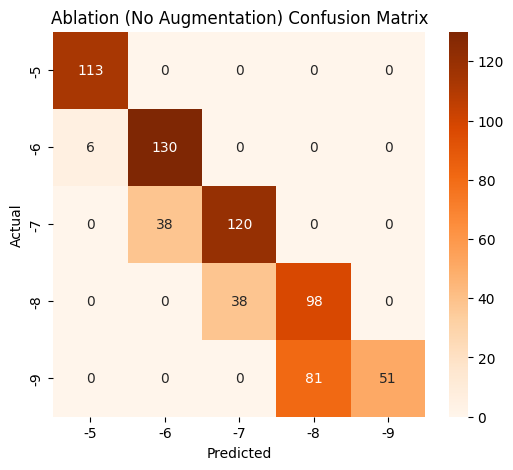

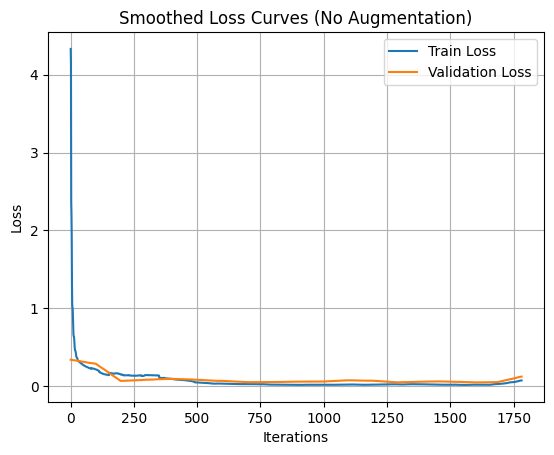

In [15]:
raw_dataset = RamanSpectraDataset(
    data_path,
    augment=False,
    offline_aug=False
)
train_raw, val_raw, test_raw = random_split(raw_dataset, [train_size, val_size, test_size])
train_raw_loader = DataLoader(train_raw, batch_size=32, shuffle=True)
val_raw_loader = DataLoader(val_raw, batch_size=32)
test_raw_loader = DataLoader(test_raw, batch_size=32)

ablation_model = ResNet(
    hidden_sizes=best_hidden,
    num_blocks=[2, 2, 2],
    input_dim=input_dim,
    n_classes=1
).to(device)

ablation_optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_lr)

ablation_train_losses, ablation_val_losses = [], []
ablation_train_batch_losses = []
ablation_val_batch_losses = []

for epoch in range(1, 21):
    train_loss, _, _, _, _, _, train_batches = run_epoch(epoch, ablation_model, train_raw_loader, cuda=torch.cuda.is_available(), training=True, optimizer=ablation_optimizer)
    val_loss, _, _, _, _, _, val_batches = run_epoch(epoch, ablation_model, val_raw_loader, cuda=torch.cuda.is_available(), training=False)

    ablation_train_losses.append(train_loss)
    ablation_val_losses.append(val_loss)
    ablation_train_batch_losses.extend(train_batches)
    ablation_val_batch_losses.extend(val_batches)

test_loss, test_mae, test_rmse, test_r2, test_kappa, test_conf, _ = run_epoch(
    "Test-Ablation", ablation_model, test_raw_loader, cuda=torch.cuda.is_available(), training=False
)

print("\nAblation (No Augmentation) Test Results:")
print(f"  Loss={test_loss:.4f}, MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, R2={test_r2:.4f}, Kappa={test_kappa:.4f}")

ablation_preds = []
ablation_actuals = []

ablation_model.eval()
with torch.no_grad():
    for x, y in test_raw_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = ablation_model(x).squeeze()
        preds = [min(-5, max(-9, int(round(p.item())))) for p in outputs]
        labels = [int(round(t.item())) for t in y]

        ablation_preds.extend(preds)
        ablation_actuals.extend(labels)


ablation_confusion_df = pd.DataFrame(test_conf, index=[-5, -6, -7, -8, -9], columns=[-5, -6, -7, -8, -9])
plt.figure(figsize=(6,5))
sns.heatmap(ablation_confusion_df, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ablation (No Augmentation) Confusion Matrix")
plt.savefig("confusion_matrix_ablation.png")

print("\nAblation Model Classification Report:")
print(classification_report(ablation_actuals, ablation_preds, labels=[-5, -6, -7, -8, -9], target_names=target_names))

ablation_acc = accuracy_score(ablation_actuals, ablation_preds)
print(f"Ablation Test Accuracy: {ablation_acc:.3f}")

def plot_loss_graph_ablation(loss_list):
    plt.figure()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    train_loss = loss_list[0]
    val_loss = loss_list[1]

    if len(train_loss) > len(val_loss):
        val_loss_interp = np.interp(
            np.linspace(0, len(val_loss) - 1, len(train_loss)),
            np.arange(len(val_loss)),
            val_loss
        )
    else:
        val_loss_interp = val_loss

    filter_size = max(1, len(train_loss) // 10)
    kernel = np.ones(filter_size) / filter_size
    train_smoothed = np.convolve(train_loss, kernel, mode='valid')
    val_smoothed = np.convolve(val_loss_interp, kernel, mode='valid')

    plt.plot(train_smoothed, label='Train Loss')
    plt.plot(val_smoothed, label='Validation Loss')
    plt.legend()
    plt.title("Smoothed Loss Curves (No Augmentation)")
    plt.grid(True)
    plt.savefig("loss_plot_ablation.png")

plot_loss_graph_ablation([ablation_train_batch_losses, ablation_val_batch_losses])